# Reinforcement Learning Lesson #1 Q-Learning (Frozen Lake 8x8)


## Markov Decision Process Components 

1. **Agent**: Part of the system that is actually going to take actions and actively effect the environment.
1. **Environment**: Part of the system that is responsibel for the effect of the actions that an agent takes
1. **Action**: The action an agent takes
1. **Reward**: The reqard the agent recives from the environment based on the action the agent takes
1. **State**: Contains all the information from the environment that is needed to take an action (current action only depends on current state)

### Block Diagram

![Markov Decision Process](https://miro.medium.com/max/1000/1*4EYA7briZGjnnhqct-tgXw.png "Markov Decision Process")


## Expected Return

The total reward expected from a state at time t is given by:

$$ G_t = R_{t+1} + R_{t+2} + \cdots + R_T $$

where $T$ is the final time step.


## Discounted Expected Return

Discount the effect of future rewards so as to indicate that immediate rewards have more importance as compared to rewards obtained far into the future.

$$ 
\begin{split}
    G_t & = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots + \gamma ^ n R_T \\
    & = \sum_{k=0}^{\infty} \gamma^{k+1} R_{t+k+1} 
\end{split}
$$

where $\gamma$ is the discount such that $0 \leq \gamma \leq 1$

$$ \gamma = 0 \Rightarrow Value only immediate reward only $$

Recurrsive equation:

$$ G_t = R_{t+1} + \gamma G_{t+1} $$


## Policy Function

Probability distribution of an agent taking an action $a$ given a state $s$ is called a policy.

This means that at time $t$, under the policy $\pi$, the probability of the agent taking the action $a$ given that it is in state $s$ is equal to $\pi(a|s)$. 

The goal is to find the optimal policy, more on this latter.


## State-Value Function

This tells us how good a state is for an agent while the agent is following a given policy.

$$ v_\pi(s) = E \: [G_t | S_t = s] $$

## Action-Value Function

This tells us how good a given action a is from $ a $ state $ s $ while the agent is following policy $ \pi $

$$ q_\pi(s,a) = E \: [G_t | S_t = s, A_t = a] $$

## Optiomal Policy

A policy such that the reward obtained by following this policy is equal to or greater that the reward that can be achieved by following any other policy.

## Optimal State-Value Function

$$ v_*(s) = max \; v_\pi(s) \; \forall \; \pi $$


## Optimal Action-Value Function

$$ q_*(s, a) = max \; q_\pi(s, a) \; \forall \; \pi $$

## Bellmam Optimality  for $q_*$

$$ q_*(s, a) = E \: [R_{t+1} + \gamma max q_*(s', a')] $$


## Update Rule

$$ q_*(s,a) = (1-\alpha) q_*(s,a) + \alpha (R_{t+1} + \gamma max q_*(s', a')) $$

where $\alpha$ is the learning rate

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import gym
import time
import random
from IPython.display import clear_output
from datetime import timedelta

# Set Random Seed to get consistant results on every run
random.seed(0)
%matplotlib inline

In [2]:
# Functions

def train(env, num_episodes, max_steps_per_episode, learning_rate, discount_rate, exploration_rate, exploration_decay_rate, min_exploration_rate, max_exploration_rate, save=False, save_fname='temp', q_table_load_file=None):
    if q_table_load_file is None:
        # Get total number of possible states and actions
        action_space_size = env.action_space.n
        state_space_size = env.observation_space.n

        # Q-Function (initialize with zeros)
        q_table = np.zeros((state_space_size, action_space_size))
    else:
        # Load Q-Function
        q_table = np.load(q_table_load_file)

    success_rate = 0
    observation = {0: 0}
    start_time = time.perf_counter()
    end_time = 0
    time_elapsed = 0
    time_required = 0

    # Loop over all the episodes
    for episode in range(1, num_episodes + 1): 
    #     Reset Environment before each episode begins
        state = env.reset()
            
    #     done keeps track of whether or not the episode has ended
        done = False
        rewards_current_episode = 0

    #     Run each step in an wpisode
        for step in range(max_steps_per_episode):
    #         Get a random exploration threshold
            exploration_rate_threshold = random.uniform(0, 1)
            
    #         Exploitation
            if exploration_rate_threshold > exploration_rate:
                action = np.argmax(q_table[state, :])
    #         Exploration
            else:
                action = env.action_space.sample()
            
    #         Take the action
            new_state, reward, done, info = env.step(action)
            
    #         Update the Q-Function
            q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))

            state = new_state
            rewards_current_episode += reward
            
    #         If episode is over break out of this loop
            if done == True:
                break
        
    #     Update Exploration Rate
        exploration_rate = min_exploration_rate + \
            (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
        success_rate += rewards_current_episode / 1000

        if episode % 1000 == 0:
            observation[episode] = success_rate
            success_rate = 0
        
            end_time = time.perf_counter()
            te = end_time - start_time
            if te > time_elapsed:
                time_elapsed = te
            time_required = int(((num_episodes - episode) / 1000) * time_elapsed)
            start_time = time.perf_counter()
        
        print(f'\rETA: {timedelta(seconds=int(time_required))}\tEpisode: {episode}/{num_episodes}\tObservation: {observation[(episode // 1000) * 1000]:.2%}\tExploration Rate: {exploration_rate:.10f}', end='')
    
    if save:
      np.save(save_fname, q_table)

    return q_table, observation

def visualize(observation):
    plt.ylim(top=1)
    plt.plot(list(observation.keys()), list(observation.values()))
    plt.ylabel('Success Rate')
    plt.xlabel('Number of Episodes')
    plt.title('Training Progress\n(Averaged over 1000 episodes)')
    plt.show()

def test(env, q_table_load_file=None, q_table=None, num_trials=1000):
    if q_table is None and q_table_load_file is None:
        random_agent = True
    else:
        random_agent = False
        
    if not random_agent and q_table is None:
        q_table = np.load(q_table_load_file)

    success_rate = 0
    tot_steps = []

    # Loop over all the episodes
    for episode in range(1, num_trials + 1): 
    #     Reset Environment before each episode begins
        state = env.reset()
        
    #     done keeps track of whether or not the episode has ended
        done = False

        steps = 0

    #     Run each step in an wpisode
        while not done:
            if random_agent:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state, :])

            new_state, reward, done, info = env.step(action)
            
            state = new_state
            steps += 1

        success_rate += reward / num_trials

        tot_steps.append((steps, reward))

        print(f'\rEpisode: {episode}/{num_trials}', end='')

    return success_rate, tot_steps

def demo(env, q_table_load_file=None, q_table=None, num_episodes=3):
    if q_table is None and q_table_load_file is None:
        random_agent = True
    else: 
        random_agent = False
        
    if not random_agent and q_table is None:
        q_table = np.load(q_table_load_file)

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        print(f'*****Episode {episode + 1}*****')
        time.sleep(1)
        
        while True:
            clear_output(wait=True)
            env.render()
            time.sleep(0.3)
            
            if random_agent:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state, :])
            
            new_state, reward, done, info = env.step(action)
            
            if done:
                clear_output(wait=True)
                env.render()

                if reward == 1:
                    print('*****You Reached Your Goal*****')
                else:
                    print('*****Fell Through A Hole*****')
                
                time.sleep(3)
                clear_output(wait=True)
                break
            
            state = new_state

In [3]:
# Get the environment
env = gym.make('FrozenLake8x8-v0')

In [4]:
# Random Agent Performance
success_rate, tot_steps = test(env, num_trials=1000)

win_steps = [steps for steps, reward in tot_steps if reward == 1]
loss_steps = [steps for steps, reward in tot_steps if reward == 0]

print('\r*****Success Rate Check*****')
print(f'Success: {success_rate:.2%}')
print('*****Step Analysis*****')
print(f'Max Steps (Wins): {max(win_steps)}\nMin Steps (wins): {min(win_steps)}\nAvg Steps (Wins): {np.average(win_steps)}')
print(f'\nMax Steps (Loss): {max(loss_steps)}\nMin Steps (Loss): {min(loss_steps)}\nAvg Steps (Loss): {np.average(loss_steps)}')

*****Success Rate Check*****
Success: 0.10%
*****Step Analysis*****
Max Steps (Wins): 146
Min Steps (wins): 146
Avg Steps (Wins): 146.0

Max Steps (Loss): 175
Min Steps (Loss): 5
Avg Steps (Loss): 31.47247247247247


In [5]:
# Random Agent Demo
demo(env, num_episodes=3)

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
*****Fell Through A Hole*****


In [6]:
# Set Hyperparameter Values
num_episodes = 100000
max_steps_per_episode = 200

learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.001
exploration_decay_rate = 0.0001

In [7]:
# TRAINING BLOCK
start_training = time.perf_counter()
q_table, observation = train(env, num_episodes, max_steps_per_episode, learning_rate, discount_rate, exploration_rate, 
                            exploration_decay_rate, min_exploration_rate, max_exploration_rate, 
                            save=True, save_fname='FrozenLake8x8-v0')
end_training = time.perf_counter()
training_time = int(end_training - start_training)
print(f'\rTraining Time: {timedelta(seconds=training_time)}{" " * 100}')

print('*****Observations*****')
for k, v in observation.items():
    print(f'{k}: {v:.2%}')

Training Time: 0:11:25                                                                                                    
*****Observations*****
0: 0.00%
1000: 0.30%
2000: 0.70%
3000: 1.20%
4000: 1.10%
5000: 2.20%
6000: 3.30%
7000: 6.40%
8000: 7.60%
9000: 8.50%
10000: 12.10%
11000: 13.30%
12000: 15.90%
13000: 19.90%
14000: 21.80%
15000: 25.20%
16000: 29.20%
17000: 31.10%
18000: 35.70%
19000: 36.30%
20000: 42.00%
21000: 44.20%
22000: 47.60%
23000: 49.90%
24000: 46.80%
25000: 53.40%
26000: 57.70%
27000: 61.80%
28000: 59.40%
29000: 60.90%
30000: 60.50%
31000: 65.70%
32000: 69.40%
33000: 66.70%
34000: 68.40%
35000: 68.40%
36000: 68.90%
37000: 73.80%
38000: 76.50%
39000: 77.20%
40000: 72.90%
41000: 77.40%
42000: 76.20%
43000: 76.80%
44000: 77.20%
45000: 82.00%
46000: 78.50%
47000: 80.40%
48000: 77.90%
49000: 79.30%
50000: 82.50%
51000: 81.80%
52000: 77.70%
53000: 82.40%
54000: 83.40%
55000: 84.00%
56000: 83.00%
57000: 83.90%
58000: 82.10%
59000: 80.80%
60000: 82.90%
61000: 79.70%
62000: 84

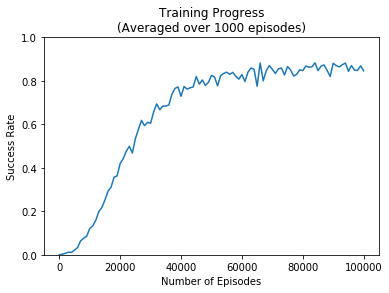

In [8]:
# VISUALIZATION OF THE TRAINING
visualize(observation)

In [9]:
# TEST BLOCK
success_rate, tot_steps = test(env, q_table=q_table, num_trials=1000)

win_steps = [steps for steps, reward in tot_steps if reward == 1]
loss_steps = [steps for steps, reward in tot_steps if reward == 0]

print('\r*****Success Rate Check*****')
print(f'Success: {success_rate:.2%}')
print('*****Step Analysis*****')
print(f'Max Steps (Wins): {max(win_steps)}\nMin Steps (wins): {min(win_steps)}\nAvg Steps (Wins): {np.average(win_steps)}')
print(f'\nMax Steps (Loss): {max(loss_steps)}\nMin Steps (Loss): {min(loss_steps)}\nAvg Steps (Loss): {np.average(loss_steps)}')

*****Success Rate Check*****
Success: 86.60%
*****Step Analysis*****
Max Steps (Wins): 199
Min Steps (wins): 20
Avg Steps (Wins): 81.63048498845265

Max Steps (Loss): 200
Min Steps (Loss): 15
Avg Steps (Loss): 99.26865671641791


In [10]:
# DEMO BLOCK
demo(env, q_table=q_table, num_episodes=3)

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
*****You Reached Your Goal*****


In [11]:
# Close env
env.close()